# Homework 2: Quantitative Strategies


## Overview
This notebook implements two quantitative portfolio strategies:

1. **Betting Against Beta (BAB):** A strategy that selects stocks with the lowest beta.
2. **Avoiding Idiosyncratic Volatility (AIV):** A strategy that selects stocks with the lowest residual volatility.

Key metrics like Sharpe ratio and maximum drawdown are calculated for performance evaluation.


### Q1. Betting against beta strategy

In crsp-monthly.csv, you can find the monthly returns of all common stocks from 2010-2023.
Starting from January 2015, use the available previous five year data (January 2010 – December 2014) in a rolling basis to estimate betas of each stock and buy 300 stocks with the lowest beta in an equal-weighted portfolio in January 2015. Re-do this ranking of betas every month (using the previous 5-year data only) and rebalance your portfolio every month.

* Compute the Sharpe ratio of your strategy.
* Compute maximum drawdown of your strategy.

Note: While estimating β, use the rf and mkt − rf factors from ff-monthly.csv which is
provided as well. Also, while computing Sharpe ratio, subtract the corresponding rf from your
monthly returns.

## Data Loading and Merging

In [1]:
import pandas as pd
import numpy as np


In [2]:
# Read data
crsp = pd.read_csv("crsp-monthly.csv")
ff_monthly = pd.read_csv("ff-monthly.csv")

## Rolling Beta Calculation

In [3]:
data = pd.merge(crsp, ff_monthly, left_on='date', right_on='dateff', how='inner')
data.head()


,PERMNO,date,SHRCD,TSYMBOL,RET,mktrf,smb,hml,rf,umd,dateff
0,10001,2010-01-29,11,EGAS,-0.018932,-0.0336,0.0040,0.0043,0.0000,-0.0540,2010-01-29
1,10001,2010-02-26,11,EGAS,-0.000656,0.0340,0.0119,0.0322,0.0000,0.0374,2010-02-26
2,10001,2010-03-31,11,EGAS,0.020643,0.0631,0.0148,0.0221,0.0001,0.0376,2010-03-31
3,10001,2010-04-30,11,EGAS,0.124385,0.0200,0.0487,0.0289,0.0001,0.0316,2010-04-30
4,10001,2010-05-28,11,EGAS,0.004829,-0.0789,0.0009,-0.0244,0.0001,-0.0025,2010-05-28


100%|██████████| 7686/7686 [01:35<00:00, 80.48it/s] 
/var/folders/86/h8k6zfgd2g14g9f0xvxh0rxr0000gn/T/ipykernel_8806/2721869986.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  selected = data.groupby('date').apply(


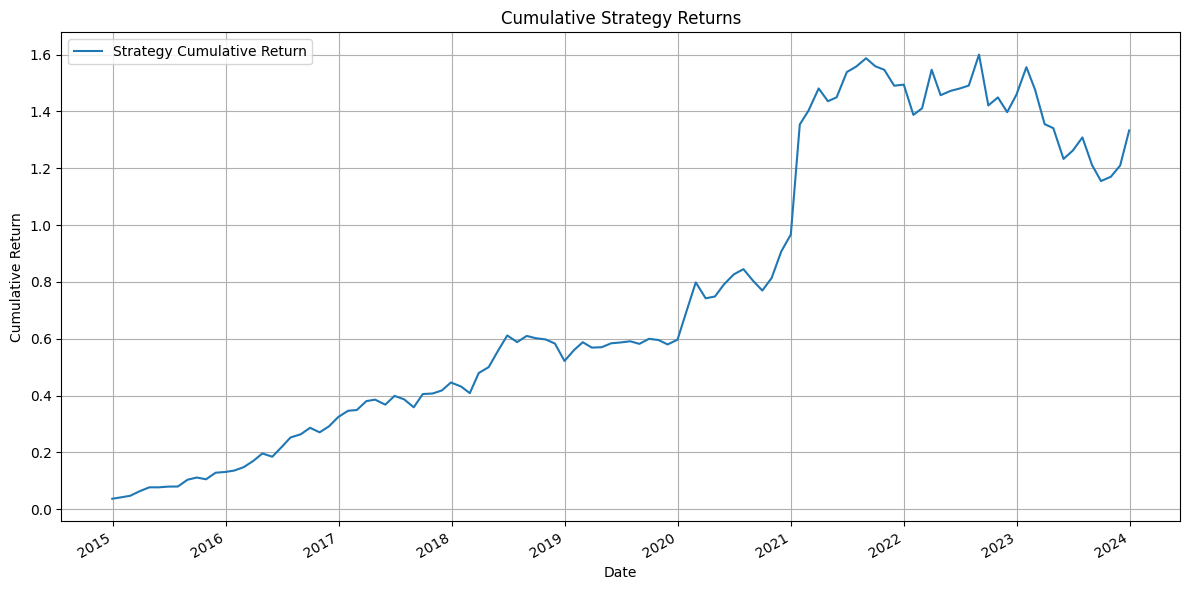

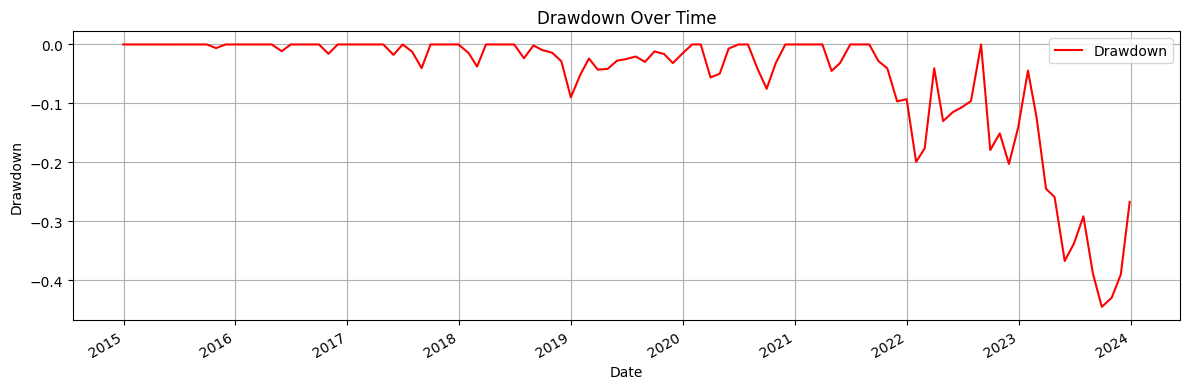


Strategy Summary Statistics:
----------------------------------------
Sharpe Ratio: 0.9468
Max Drawdown: -0.4453
Cumulative Return: 1.3331


In [5]:

import statsmodels.api as sm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm

def calculate_stock_beta(data, lookback_period=60, n_jobs=-1):
    """
    Calculate beta for each stock using a one-factor model (market excess return) over a rolling period.
    
    Parameters:
    data (pd.DataFrame): DataFrame with columns ['PERMNO', 'date', 'RET', 'mktrf', 'rf'].
    lookback_period (int): Number of months (5 years) for rolling regression.
    n_jobs (int): Number of jobs to run in parallel (-1 uses all available cores).
    
    Returns:
    pd.DataFrame: DataFrame with columns ['date', 'PERMNO', 'beta'].
    """
    # Ensure date is in datetime format and data is sorted
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['PERMNO', 'date']).reset_index(drop=True)
    
    # Convert columns to numeric
    data['RET'] = pd.to_numeric(data['RET'], errors='coerce')
    data['rf'] = pd.to_numeric(data['rf'], errors='coerce')
    data['mktrf'] = pd.to_numeric(data['mktrf'], errors='coerce')
    
    # Calculate excess returns
    data['RET_excess'] = data['RET'] - data['rf']

    def compute_stock_beta(stock_data):
        """
        Computes rolling beta for a single stock using a one-factor model.
        """
        stock_data = stock_data.set_index('date').sort_index()
        X = sm.add_constant(stock_data['mktrf'])
        
        # Calculate rolling beta
        rolling_beta = stock_data['RET_excess'].rolling(window=lookback_period, min_periods=lookback_period).apply(
            lambda y: sm.OLS(y, X.loc[y.index]).fit().params.iloc[1] if len(y.dropna()) == lookback_period else np.nan,
            raw=False
        )
        
        return pd.DataFrame({
            'date': stock_data.index,
            'PERMNO': stock_data['PERMNO'].iloc[0],
            'beta': rolling_beta
        })

    # Run the computation in parallel for each stock
    results = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(compute_stock_beta)(group) for _, group in tqdm(data.groupby('PERMNO'))
    )

    # Concatenate results and drop NaN betas
    beta_data = pd.concat(results).dropna(subset=['beta']).reset_index(drop=True)
    
    return beta_data

def implement_low_beta_strategy(data, beta_data, n_stocks=300):
    """
    Implements a low beta strategy.
    
    Parameters:
    data (pd.DataFrame): DataFrame with columns ['PERMNO', 'date', 'RET', 'mktrf', 'rf'].
    beta_data (pd.DataFrame): DataFrame with columns ['date', 'PERMNO', 'beta'].
    n_stocks (int): Number of stocks to select with the lowest beta.
    
    Returns:
    pd.DataFrame: Portfolio returns and summary statistics.
    """
    # Merge data with beta values
    data = pd.merge(data, beta_data, on=['PERMNO', 'date'], how='left')
    
    # Ensure 'RET' is numeric
    data['RET'] = pd.to_numeric(data['RET'], errors='coerce')
    
    # Remove rows with NaN in 'RET' or 'beta'
    data = data.dropna(subset=['RET', 'beta'])
    
    # Group by date and select top n_stocks with lowest beta
    selected = data.groupby('date').apply(
        lambda x: x.nsmallest(n_stocks, 'beta') if len(x) >= n_stocks else x
    ).reset_index(drop=True)
    
    # Calculate equal-weighted portfolio returns
    selected['RET_excess'] = selected['RET'] - selected['rf']
    portfolio_returns = selected.groupby('date').agg(
        portfolio_return=('RET_excess', 'mean')
    ).reset_index()
    
    # Sort by date
    portfolio_returns = portfolio_returns.sort_values('date').reset_index(drop=True)
    
    # Calculate cumulative returns
    portfolio_returns['cumulative_return'] = (1 + portfolio_returns['portfolio_return']).cumprod() - 1
    
    # Calculate Sharpe Ratio (annualized)
    sharpe_ratio = (portfolio_returns['portfolio_return'].mean() / 
                    portfolio_returns['portfolio_return'].std()) * np.sqrt(12)  # Monthly data
    
    # Calculate maximum drawdown
    portfolio_returns['cumulative_max'] = portfolio_returns['cumulative_return'].cummax()
    portfolio_returns['drawdown'] = portfolio_returns['cumulative_return'] - portfolio_returns['cumulative_max']
    max_drawdown = portfolio_returns['drawdown'].min()
    
    # Summary statistics
    summary_stats = {
        'Sharpe Ratio Annualized': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Cumulative Return': portfolio_returns['cumulative_return'].iloc[-1]
    }
    
    # Visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    portfolio_returns.plot(x='date', y='cumulative_return', ax=ax, label='Strategy Cumulative Return')
    ax.set_title('Cumulative Strategy Returns')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Return')
    ax.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot drawdown
    fig, ax = plt.subplots(figsize=(12, 4))
    portfolio_returns.plot(x='date', y='drawdown', ax=ax, color='red', label='Drawdown')
    ax.set_title('Drawdown Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Drawdown')
    ax.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return portfolio_returns, summary_stats

# Example Usage
if __name__ == "__main__":
    # Ensure 'data' is loaded correctly. For example:
    # data = pd.read_csv('merged_data.csv')

    try:
        data
    except NameError:
        print("DataFrame 'data' is not defined. Please load your data before running the strategy.")

    # Calculate beta values
    beta_data = calculate_stock_beta(data, lookback_period=60, n_jobs=-1)  # Use all cores for speed
    
    # Implement the strategy
    portfolio_returns_low_beta, summary_stats_low_beta = implement_low_beta_strategy(data, beta_data, n_stocks=300)
    
    # Print summary statistics
    print("\nStrategy Summary Statistics:")
    print("-" * 40)
    for stat, value in summary_stats_low_beta.items():
        if isinstance(value, float):
            print(f"{stat}: {value:.4f}")
        else:
            print(f"{stat}: {value}")


### 2. Avoid idiosyncratic volatility

Now using similar approach as in the previous question, estimate the residual volatility of each stock in the same one-factor model using the previous five-year data and buy 300 stocks with the lowest residual volatility starting from January 2015. Re-do this ranking of residual volatility every month (using the previous 5-year data only) and rebalance your portfolio every month.

* Compute the Sharpe ratio of your strategy.
* Compute maximum drawdown of your strategy.

## Portfolio Construction and Backtesting

100%|██████████| 7686/7686 [01:24<00:00, 91.42it/s] 
/var/folders/86/h8k6zfgd2g14g9f0xvxh0rxr0000gn/T/ipykernel_8806/3072317679.py:82: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  selected = data.groupby('date').apply(


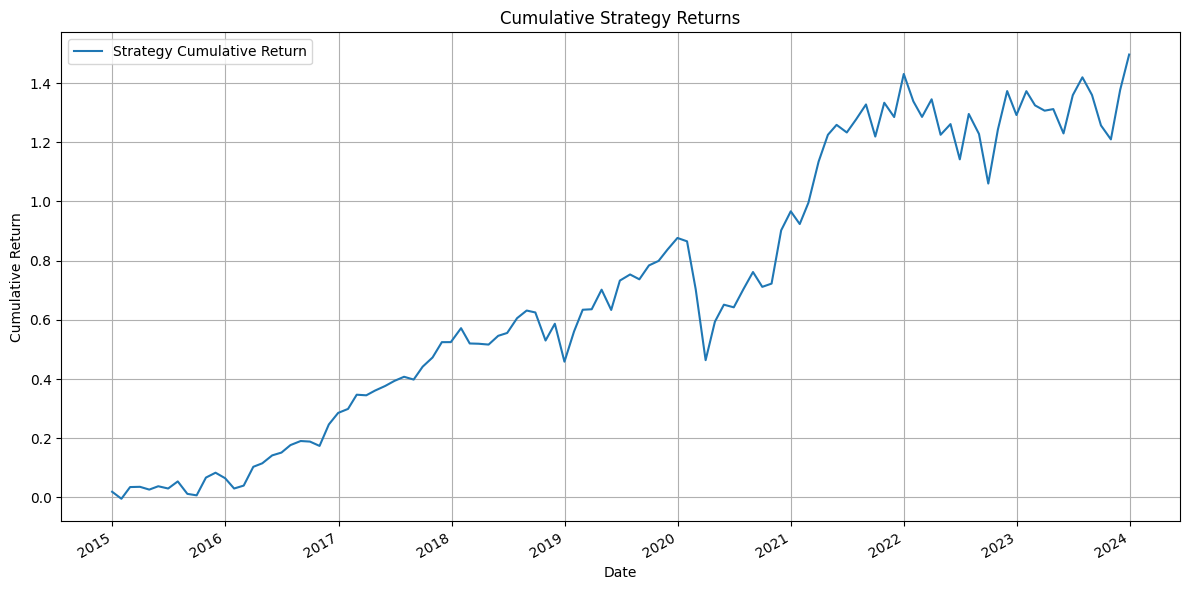

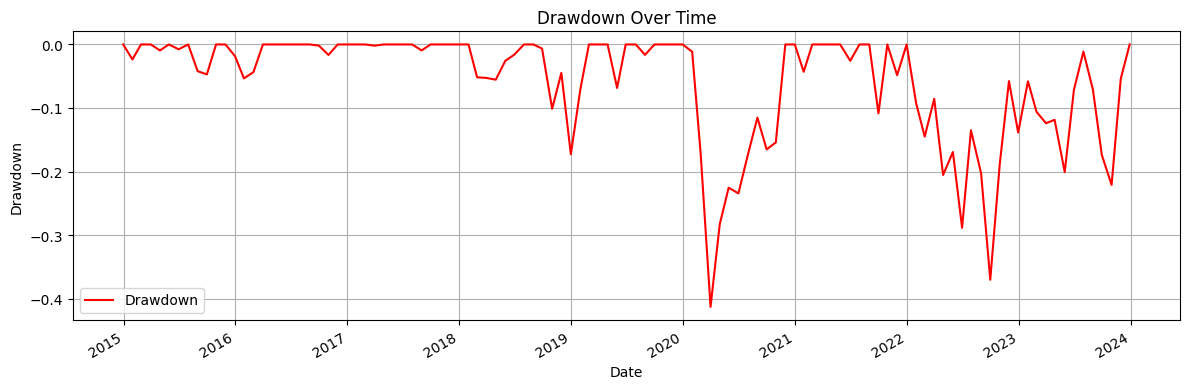


Strategy Summary Statistics:
----------------------------------------
Sharpe Ratio (Annualized): 0.8078
Max Drawdown: -0.4129
Cumulative Return: 1.4966


In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed  # For parallel processing
from tqdm import tqdm  # For progress bars

def calculate_residual_volatility(data, lookback_period=60, n_jobs=-1):
    """
    Calculate residual volatility for each stock using a one-factor model (market excess return).
    
    Parameters:
    data (pd.DataFrame): DataFrame with columns ['PERMNO', 'date', 'RET', 'mktrf', 'rf'].
    lookback_period (int): Number of months (5 years) for rolling regression.
    n_jobs (int): Number of jobs to run in parallel (-1 uses all available cores).
    
    Returns:
    pd.DataFrame: DataFrame with columns ['date', 'PERMNO', 'residual_vol'].
    """
    # Ensure date is in datetime format and data is sorted
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['PERMNO', 'date']).reset_index(drop=True)
    
    # Convert to numeric types
    data['RET'] = pd.to_numeric(data['RET'], errors='coerce')
    data['rf'] = pd.to_numeric(data['rf'], errors='coerce')
    data['mktrf'] = pd.to_numeric(data['mktrf'], errors='coerce')
    
    # Calculate excess returns
    data['RET_excess'] = data['RET'] - data['rf']

    def compute_stock_residual_volatility(stock_data):
        """
        Computes rolling residual volatility for a single stock.
        """
        stock_data = stock_data.set_index('date').sort_index()
        X = sm.add_constant(stock_data['mktrf'])
        
        rolling_resid_std = stock_data['RET_excess'].rolling(window=lookback_period, min_periods=lookback_period).apply(
            lambda y: np.std(sm.OLS(y, X.loc[y.index]).fit().resid) if len(y.dropna()) == lookback_period else np.nan,
            raw=False
        )
        
        return pd.DataFrame({
            'date': stock_data.index,
            'PERMNO': stock_data['PERMNO'].iloc[0],
            'residual_vol': rolling_resid_std
        })

    # Run the computation in parallel for each stock
    results = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(compute_stock_residual_volatility)(group) for _, group in tqdm(data.groupby('PERMNO'))
    )

    # Concatenate results and drop NaN residuals
    residual_vol = pd.concat(results).dropna(subset=['residual_vol']).reset_index(drop=True)
    
    return residual_vol

def implement_low_volatility_strategy(data, residual_vol, n_stocks=300):
    """
    Implements a low residual volatility strategy.
    
    Parameters:
    data (pd.DataFrame): DataFrame with columns ['PERMNO', 'date', 'RET', 'mktrf', 'rf'].
    residual_vol (pd.DataFrame): DataFrame with columns ['date', 'PERMNO', 'residual_vol'].
    n_stocks (int): Number of stocks to select with the lowest residual volatility.
    
    Returns:
    pd.DataFrame: Portfolio returns and summary statistics.
    """
    # Merge data with residual volatility
    data = pd.merge(data, residual_vol, on=['PERMNO', 'date'], how='left')
    
    # Ensure 'RET' is numeric
    data['RET'] = pd.to_numeric(data['RET'], errors='coerce')
    
    # Remove rows with NaN in 'RET' or 'residual_vol'
    data = data.dropna(subset=['RET', 'residual_vol'])
    
    # Group by date and select top n_stocks with lowest residual_vol
    selected = data.groupby('date').apply(
        lambda x: x.nsmallest(n_stocks, 'residual_vol') if len(x) >= n_stocks else x
    ).reset_index(drop=True)
    
    # Calculate equal-weighted portfolio returns
    portfolio_returns = selected.groupby('date').agg(
        portfolio_return=('RET', 'mean')
    ).reset_index()
    
    # Sort by date
    portfolio_returns = portfolio_returns.sort_values('date').reset_index(drop=True)
    
    # Calculate cumulative returns
    portfolio_returns['cumulative_return'] = (1 + portfolio_returns['portfolio_return']).cumprod() - 1
    
    # Calculate Sharpe Ratio (annualized)
    sharpe_ratio = (portfolio_returns['portfolio_return'].mean() / 
                    portfolio_returns['portfolio_return'].std()) * np.sqrt(12)  # Monthly data
    
    # Calculate maximum drawdown
    portfolio_returns['cumulative_max'] = portfolio_returns['cumulative_return'].cummax()
    portfolio_returns['drawdown'] = portfolio_returns['cumulative_return'] - portfolio_returns['cumulative_max']
    max_drawdown = portfolio_returns['drawdown'].min()
    
    # Summary statistics
    summary_stats = {
        'Sharpe Ratio (Annualized)': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Cumulative Return': portfolio_returns['cumulative_return'].iloc[-1]
    }
    
    # Visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    portfolio_returns.plot(x='date', y='cumulative_return', ax=ax, label='Strategy Cumulative Return')
    ax.set_title('Cumulative Strategy Returns')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Return')
    ax.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot drawdown
    fig, ax = plt.subplots(figsize=(12, 4))
    portfolio_returns.plot(x='date', y='drawdown', ax=ax, color='red', label='Drawdown')
    ax.set_title('Drawdown Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Drawdown')
    ax.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return portfolio_returns, summary_stats

# Example Usage
if __name__ == "__main__":
    # Ensure 'data' is loaded correctly. For example:
    # data = pd.read_csv('merged_data.csv')

    try:
        data
    except NameError:
        print("DataFrame 'data' is not defined. Please load your data before running the strategy.")

    # Calculate residual volatility
    residual_vol = calculate_residual_volatility(data, lookback_period=60, n_jobs=-1)  # Use all cores for speed
    
    # Implement the strategy
    portfolio_returns_low_volatility, summary_stats_low_volatility = implement_low_volatility_strategy(data, residual_vol, n_stocks=300)

    # Print summary statistics
    print("\nStrategy Summary Statistics:")
    print("-" * 40)
    for stat, value in summary_stats_low_volatility.items():
        if isinstance(value, float):
            print(f"{stat}: {value:.4f}")
        else:
            print(f"{stat}: {value}")


### 3. Combine both strategies optimally
Using the portfolio returns from both strategies that you computed in Questions 1 and 2, now answer the following questions:
* What is the correlation between two strategies?
* What is the Sharpe ratio of a portfolio that puts 50% to each strategy?
* What should be the optimal weight of each strategy if you are aiming to maximize the
Sharpe ratio of the overall portfolio.

In [11]:
combined_returns = pd.merge(portfolio_returns_low_volatility, portfolio_returns_low_beta, on='date', suffixes=('_low_vol', '_low_beta'))
combined_returns.head()

,date,portfolio_return_low_vol,cumulative_return_low_vol,cumulative_max_low_vol,drawdown_low_vol,portfolio_return_low_beta,cumulative_return_low_beta,cumulative_max_low_beta,drawdown_low_beta
0,2014-12-31,0.019182,0.019182,0.019182,0.000000,0.036682,0.036682,0.036682,0.0
1,2015-01-30,-0.023222,-0.004485,0.019182,-0.023667,0.005115,0.041985,0.041985,0.0
2,2015-02-27,0.039711,0.035048,0.035048,0.000000,0.004972,0.047165,0.047165,0.0
3,2015-03-31,0.000798,0.035874,0.035874,0.000000,0.016010,0.063931,0.063931,0.0
4,2015-04-30,-0.009058,0.026491,0.035874,-0.009383,0.012228,0.076941,0.076941,0.0


In [14]:
# Question 1: Calculate the correlation between the two strategies
def calculate_correlation(portfolio_returns_low_volatility, portfolio_returns_low_beta):
    # Merge on 'date' to align the returns of both strategies
    combined_returns = pd.merge(portfolio_returns_low_volatility, portfolio_returns_low_beta, on='date', suffixes=('_low_vol', '_low_beta'))
    
    # Calculate the correlation
    correlation = combined_returns[['portfolio_return_low_vol', 'portfolio_return_low_beta']].corr().iloc[0, 1]
    return correlation

# Calculate correlation
correlation = calculate_correlation(portfolio_returns_low_volatility, portfolio_returns_low_beta)
print(f"Correlation between the two strategies: {correlation:.4f}")

# Question 2: Calculate the Sharpe ratio of a portfolio with 50% weight to each strategy
def calculate_sharpe_ratio(portfolio_returns_low_volatility, portfolio_returns_low_beta, weight_vol=0.5, weight_beta=0.5):
    # Merge on 'date' to align the returns of both strategies
    combined_returns = pd.merge(portfolio_returns_low_volatility, portfolio_returns_low_beta, on='date', suffixes=('_low_vol', '_low_beta'))
    
    # Calculate the weighted returns for a 50-50 portfolio
    combined_returns['portfolio_return'] = weight_vol * combined_returns['portfolio_return_low_vol'] + weight_beta * combined_returns['portfolio_return_low_beta']
    
    # Calculate the Sharpe ratio (annualized, assuming monthly data)
    sharpe_ratio = (combined_returns['portfolio_return'].mean() / combined_returns['portfolio_return'].std()) * np.sqrt(12)
    return sharpe_ratio

# Calculate Sharpe ratio for 50-50 portfolio
sharpe_ratio_50_50 = calculate_sharpe_ratio(portfolio_returns_low_volatility, portfolio_returns_low_beta, weight_vol=0.5, weight_beta=0.5)
print(f"Sharpe Ratio for 50-50 portfolio: {sharpe_ratio_50_50:.4f}")

# Question 3: Calculate the optimal weights for maximizing the Sharpe ratio
def calculate_optimal_weights(portfolio_returns_low_volatility, portfolio_returns_low_beta):
    # Merge on 'date' to align the returns of both strategies
    combined_returns = pd.merge(portfolio_returns_low_volatility, portfolio_returns_low_beta, on='date', suffixes=('_low_vol', '_low_beta'))
    
    # Calculate the covariance matrix of the two strategies' returns
    cov_matrix = combined_returns[['portfolio_return_low_vol', 'portfolio_return_low_beta']].cov()
    
    # Calculate the expected returns of the two strategies
    expected_returns = combined_returns[['portfolio_return_low_vol', 'portfolio_return_low_beta']].mean()
    
    # Calculate the weights that maximize the Sharpe ratio using mean-variance optimization
    # Formula: w = (cov_matrix_inv * expected_returns) / sum(cov_matrix_inv * expected_returns)
    cov_matrix_inv = np.linalg.inv(cov_matrix)
    weights = cov_matrix_inv.dot(expected_returns) / np.sum(cov_matrix_inv.dot(expected_returns))
    
    return weights

# Calculate optimal weights
optimal_weights = calculate_optimal_weights(portfolio_returns_low_volatility, portfolio_returns_low_beta)
print(f"Optimal weights for each strategy (low_vol, low_beta): {optimal_weights}")


Correlation between the two strategies: 0.2253
Sharpe Ratio for 50-50 portfolio: 1.1026
Optimal weights for each strategy (low_vol, low_beta): [0.37230819 0.62769181]


### 4.Implementation in Alpaca
Pick one of the strategies that you liked in Question 1 or 2 and fully implement in Alpaca going forward. To get the full universe of common stocks, you can use asset_class=AssetClass.US_EQUITY in your request_params function. Since you will not have access to real-time Fama-French factors, use SPY for market returns and use a monthly risk-free rate of 0.4%. Rebalance your portfolio using MOC orders and every 21 days at 3:45pm. Automate it using APScheduler package.

Implementing Low Beta Stock Strat

In [ ]:
# Add necessary imports
from alpaca_trade_api import REST, TimeFrame
from apscheduler.schedulers.blocking import BlockingScheduler

API_KEY = 'PKIUZHYD6TN7L71G744C'
SECRET_KEY = '5fes3jXiiMdSDSaz2HgJNHA8q1bqStfouwzIsykt'
BASE_URL = 'https://paper-api.alpaca.markets'

# Initialize Alpaca API
alpaca_api = REST(API_KEY, SECRET_KEY, BASE_URL)

# Function to fetch stock universe
def fetch_stock_universe():
    # Fetch US equity assets
    assets = alpaca_api.list_assets(asset_class='us_equity')
    return [asset.symbol for asset in assets if asset.status == 'active']

# Function to rebalance portfolio
def rebalance_portfolio():
    print("Starting portfolio rebalance process...")
    
    # Fetch stock universe
    stock_universe = fetch_stock_universe()
    print(f"Fetched {len(stock_universe)} active stocks from Alpaca.")

    # Calculate betas and select low beta stocks
    print("Calculating betas for stocks...")
    beta_data = calculate_stock_beta(data, lookback_period=60, n_jobs=-1)  # Use your existing function
    print("Beta calculation complete.")

    selected_stocks = beta_data.nsmallest(300, 'beta')['PERMNO'].tolist()  # Select lowest beta stocks
    print(f"Selected {len(selected_stocks)} stocks with the lowest beta.")

    # Place MOC orders for selected stocks
    for stock in selected_stocks:
        alpaca_api.submit_order(
            symbol=stock,
            qty=1,  # Adjust quantity as needed
            side='buy',
            type='market',
            time_in_force='moc'  # Market on Close order
        )
    print(f"Rebalanced portfolio with stocks: {selected_stocks}")
    print("Portfolio rebalance process completed.")

# Schedule the rebalance every 21 days at 3:45 PM
scheduler = BlockingScheduler()
scheduler.add_job(rebalance_portfolio, 'cron', day='*/21', hour=15, minute=45)

# Start the scheduler
scheduler.start()


## Results Summary

The results include:
1. Sharpe ratios for both strategies.
2. Maximum drawdown.
3. Combined strategy performance.
